# CSE 482 Final Project

#  <p style="text-align: center;"> Quantifying Luck in College Football 
## <p style="text-align: center;"> Teammates: John Foss, Josiah Hill, Michael Guel, Peter Imoukhuede, Zachary Gage

## Context

The primary objective of our project is to predict scoring for college football teams based on other team statistics. Teams that outscore our predictions might be seen as "lucky" while teams that underperform might be considered "unlucky". Identifying games with high "luck" would provide us a subset of data for a future project that could analyze what "luck" really represents.

The site CollegeFootballData.com provides a large amount of historic data on college football games. For our purposes, we have extracted data on every game played by a power-5 team over the last seven years, excluding 2020. Power-5 teams are teams from the ACC, SEC, Big 10, Big 12, and PAC 12, which are considered the premier conferences in college football. We only include these teams because they generally operate with a similar level of financial resources and have a more equal level of player performance in comparison to other conferences. We also exclude the year 2020 because we don't believe that the data from that year will follow the same trends as other years due to COVID-related complications.  

Our training data will consist of the data from 2017-19, 2021, and 2022. Given this data, we will identify and remove statistics that correlate too strongly with scoring (like touchdowns). We will use EDA to understand the distribution of our various features and potentially identify other features to exclude. Then we will compare various modeling techniques, such as linear regression, random forest, and xgboost, to identify the highest performing technique. Then we can perform a grid search to optimize the hyperparameters and finalize our model. We can then apply our model to our test data (2023) and visualize the results to see how luck is distributed across teams.

## Data Dictionary:

* `Game Id`: Identifier for each game.
* `School`: Name of the school.
* `Conference`: Conference of the school.
* `HomeAway`: Whether the team was home or away.
* `Points`: Points scored in the game.
* `firstDowns`: Number of first downs.
* `fumblesLost`: Number of fumbles lost.
* `fumblesRecovered`: Number of fumbles recovered.
* `interceptionYards`: Yards gained from interceptions.
* `interceptions`: Number of interceptions.
* `kickReturnYards`: Yards gained from kick returns.
* `kickReturns`: Number of kick returns.
* `netPassingYards`: Net yards gained by passing.
* `passesDeflected`: Number of passes deflected.
* `passesIntercepted`: Number of passes intercepted.
* `possessionTime`: Time of possession in seconds.
* `puntReturnYards`: Yards gained from punt returns.
* `puntReturns`: Number of punt returns.
* `qbHurries`: Number of quarterback hurries.
* `rushingAttempts`: Number of rushing attempts.
* `rushingYards`: Yards gained by rushing.
* `sacks`: Number of sacks.
* `tackles`: Number of tackles.
* `tacklesForLoss`: Tackles for a loss.
* `totalFumbles`: Total number of fumbles.
* `totalYards`: Total yards gained.
* `turnovers`: Total turnovers.
* `yardsPerPass`: Average yards gained per pass.
* `yardsPerRushAttempt`: Average yards gained per rush attempt.
* `completions`: Number of completed passes.
* `attempts`: Number of pass attempts.
* `thirdDownsConverted`: Third downs converted.
* `thirdDownAttempts`: Third down attempts.
* `fourthDownsConverted`: Fourth downs converted.
* `fourthDownAttempts`: Fourth down attempts.
* `totalPenalties`: Total number of penalties.
* `penaltiesYards`: Yards lost due to penalties.


## Loading Libraries

In [1]:
# Libraries to help with reading and manipulating data
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Libraries to help with data visualization
import seaborn as sns

# Library for building a  models
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor
from scipy import stats as ss
from sklearn.ensemble import RandomForestRegressor

# Library to impute missing values
from sklearn.impute import KNNImputer
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Libraries to tune model, get different metric scores, and split data
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.pipeline import make_pipeline

# Library to help with normalizing variables
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tpot import TPOTRegressor
from tpot.builtins import StackingEstimator

In [2]:
# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Removes the limit from the number of displayed columns.
pd.set_option("display.max_columns", None)

# Set visualization style
plt.style.use("tableau-colorblind10")
plt.rc("figure", figsize=(12, 8))
pio.templates.default = "plotly_white"

## Read the data into the notebook

In [3]:
game_df = pd.read_csv("All_Games.csv")

## Overview of data

In [4]:
game_df.head()

Game Id    School Conference HomeAway  Points    Stat Category Stat
0  400937451  Syracuse        ACC     home      50       rushingTDs    3
1  400937451  Syracuse        ACC     home      50  puntReturnYards    7
2  400937451  Syracuse        ACC     home      50    puntReturnTDs    0
3  400937451  Syracuse        ACC     home      50      puntReturns    5
4  400937451  Syracuse        ACC     home      50       passingTDs    3

In [5]:
np.random.seed(42)
game_df.sample(n=5)

Game Id     School Conference HomeAway  Points       Stat Category  \
59338   401403868    Alabama        SEC     away      20        defensiveTDs   
58917   401404112   Oklahoma     Big 12     away      20       kickReturnTDs   
14692   401112433   Virginia        ACC     away      30         puntReturns   
36205   401525492  Lafayette    Patriot     away       7  completionAttempts   
172168  401520196   Kentucky        SEC     home      28          totalYards   

        Stat  
59338      0  
58917      0  
14692      3  
36205   9-18  
172168   414

**Observations**
* `Points` is the target variable.
*  We should pivot the dataframe so that each `Stat Category` is a column with values matching `Stat`

In [6]:
# Pivot the dataframe so that each stat category is a column
game_df = game_df.pivot_table(
    index=["Game Id", "School", "Conference", "HomeAway", "Points"],
    columns="Stat Category",
    values="Stat",
    aggfunc="first",
).reset_index()

# Flatten the MultiIndex for columns if it exists
game_df.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in game_df.columns.values
]

In [7]:
game_df.head()

Game Id         School Conference HomeAway  Points completionAttempts  \
0  400933827        Alabama        SEC     home      24              10-18   
1  400933827  Florida State        ACC     away       7              19-33   
2  400933828       Arkansas        SEC     home      49              16-22   
3  400933828    Florida A&M       MEAC     away       7              14-29   
4  400933829         Auburn        SEC     home      41              15-26   

  defensiveTDs firstDowns fourthDownEff fumblesLost fumblesRecovered  \
0            0         13           2-2           0                1   
1            0         15           0-1           1                0   
2            0         26           0-0           0                1   
3            0          9           3-4           1                0   
4            0         25           2-3           2                0   

  interceptionTDs interceptionYards interceptions kickReturnTDs  \
0               0                 0             0             0   
1             NaN               NaN             2             0   
2             NaN               NaN             1             0   
3               0                 0             0             0   
4               0                 0             1             0   

  kickReturnYards kickReturns kickingPoints netPassingYards passesDeflected  \
0              15           1            10              96               6   
1              20           2             1             210               1   
2              37           2             7             179               2   
3              39           3             1              95               1   
4              29           1            11             184               1   

  passesIntercepted passingTDs possessionTime puntReturnTDs puntReturnYards  \
0                 2          1          32:47             0              19   
1               NaN          1          27:13           NaN             NaN   
2               NaN          2          34:30           NaN             NaN   
3                 1          1          25:30           NaN             NaN   
4                 1          2          30:32             0               6   

  puntReturns qbHurries rushingAttempts rushingTDs rushingYards sacks tackles  \
0           1         0              42          1          173     3      30   
1         NaN         0              27          0           40     2      26   
2         NaN         2              45          4          236     3      30   
3         NaN         1              31          0           80     2      30   
4           1         5              53          3          351     5      34   

  tacklesForLoss thirdDownEff totalFumbles totalPenaltiesYards totalYards  \
0              9         3-16          NaN                5-30        269   
1              4         4-13            1                4-30        250   
2              6         7-10            0                2-20        415   
3              5         3-16            1                7-55        175   
4             12         6-16            4                4-42        535   

  turnovers yardsPerPass yardsPerRushAttempt  
0         0          5.3                 4.1  
1         3          6.4                 1.5  
2         1          8.1                 5.2  
3         1          3.3                 2.6  
4         3          7.1                 6.6

In [8]:
game_df["Conference"].value_counts()

Conference
SEC                  920
Big Ten              918
ACC                  910
Pac-12               788
Big 12               677
Mid-American         123
FBS Independents     120
Mountain West        109
Conference USA       101
American Athletic    100
Sun Belt              85
Big Sky               52
Southern              44
MVFC                  37
CAA                   34
OVC                   25
Southland             19
SWAC                  19
MEAC                  18
Big South             11
NEC                   11
Patriot                8
UAC                    7
Western Athletic       4
AWC                    3
Big South-OVC          3
Atlantic Sun           2
FCS Independents       1
Pioneer                1
Name: count, dtype: int64

**Observations**

* Since we are only interested in Power-5 teams, they need to be extracted from the dataset. Power-5 teams are teams from the ACC, SEC, Big 10, Big 12, and PAC 12, which are considered the premier conferences in college football.
* The data needs to be cleaned and almost all the variables are in the wrong data format.
* We should drop the variables associated with the types of Touchdowns since they are same as `Points`.
* We should drop `kickingPoints` since is the same as `Points`.

In [9]:
# Drop mid-major teams
p5 = ["ACC", "SEC", "Big Ten", "Big 12", "Pac-12"]
game_df = game_df[game_df["Conference"].isin(p5)]

In [10]:
# TD columns (to drop)
tds = [
    "rushingTDs",
    "passingTDs",
    "kickReturnTDs",
    "interceptionTDs",
    "defensiveTDs",
    "puntReturnTDs",
    "kickingPoints",
]
game_df = game_df.drop(columns=tds)

### Data Cleaning

In [11]:
unique_values = {col: game_df[col].unique() for col in game_df.columns[4:]}
unique_values

{'Points': array([24,  7, 49, 41, 17, 33, 31, 27, 47, 72, 28, 35, 44, 45, 42,  6, 14,
        20, 57, 13, 26, 16, 37,  3, 23, 43, 50, 51, 59,  0, 66, 10, 38, 21,
        40, 34, 22, 48, 19,  9, 53, 15, 52, 68, 29, 39, 55, 56, 36, 30, 63,
        65, 46, 62, 58, 18, 77, 54, 25, 69, 12, 60, 64, 32, 61, 76, 70, 74,
        79, 73,  2, 67,  8, 11, 81], dtype=int64),
 'completionAttempts': array(['10-18', '19-33', '16-22', '15-26', '14-26', '12-26', '11-20',
        '15-18', '28-35', '20-36', '21-34', '45-64', '17-29', '9-30',
        '35-59', '20-28', '5-10', '20-37', '20-27', '9-23', '21-31',
        '13-24', '20-31', '16-29', '16-24', '9-18', '32-43', '13-20',
        '14-32', '18-28', '17-30', '24-36', '19-26', '13-21', '32-37',
        '21-39', '9-15', '24-48', '26-44', '13-29', '15-23', '12-28',
        '26-34', '16-26', '24-37', '10-28', '14-23', '13-27', '14-27',
        '9-12', '15-33', '17-27', '18-27', '34-55', '16-21', '23-39',
        '22-35', '19-32', '7-22', '15-24', '14-29',

**Observations**

* `completionAttempts`: This column is formatted as 'number-number' (e.g., '10-18'), which appears to represent completed attempts versus total attempts.
* `thirdDownEff` and `fourthDownEff`: These columns are also in a 'number-number' format representing successful attempts versus total attempts.
* `totalPenaltiesYards`: The format is 'number-number' likely representing the number of penalties and the total yards penalized.
* We will split `completionAttempts`, `totalPenaltiesYards`, `thirdDownEff` and `fourthDownEff` into two new columns based on a delimiter ('-') and the original columns will be dropped from the dataframe.
* `possessionTime`: We will convert this from 'mm:ss' or 'mm:ss:milliseconds' format into total seconds for easier analysis.

In [12]:
def convert_possession_time(time_str):
    """
    Convert possession time from 'mm:ss' or 'mm:ss:milliseconds' format to total seconds.
    Handles non-string inputs gracefully.
    """
    if pd.isna(time_str) or not isinstance(time_str, str):
        return None

    match = re.match(r"(\d+):(\d+)(?::\d+)?", time_str)
    if match:
        minutes, seconds = match.groups()[:2]
        return int(minutes) * 60 + int(seconds)
    return None

In [13]:
# Convert "possessionTime" column to Seconds
game_df["possessionTime"] = game_df["possessionTime"].apply(convert_possession_time)

In [14]:
# Function to split a column in 'number-number' format into two separate columns
def split_ratio_columns(df, column_name, new_col1, new_col2):
    """
    Split a column in 'number-number' format into two separate columns.
    """
    # Splitting the column and creating two new columns
    df[new_col1], df[new_col2] = zip(
        *df[column_name].apply(lambda x: x.split("-") if pd.notna(x) else (None, None))
    )
    df = df.drop(column_name, axis=1)

    # Converting new columns to numeric type
    df[new_col1] = pd.to_numeric(df[new_col1], errors="coerce")
    df[new_col2] = pd.to_numeric(df[new_col2], errors="coerce")

    return df

In [15]:
# Splitting and renaming the 'completionAttempts', 'thirdDownEff', 'fourthDownEff', and 'totalPenaltiesYards' columns
game_df = split_ratio_columns(game_df, "completionAttempts", "completions", "attempts")
game_df = split_ratio_columns(
    game_df, "thirdDownEff", "thirdDownsConverted", "thirdDownAttempts"
)
game_df = split_ratio_columns(
    game_df, "fourthDownEff", "fourthDownsConverted", "fourthDownAttempts"
)
game_df = split_ratio_columns(
    game_df, "totalPenaltiesYards", "totalPenalties", "penaltiesYards"
)

### Data Type Conversion

In [16]:
# Convert continuous variables to numeric type
numeric_columns = game_df.columns[4:].tolist()

for col in numeric_columns:
    game_df[col] = pd.to_numeric(game_df[col])

### Dataset Shape

In [17]:
print(f"There are {game_df.shape[0]} rows and {game_df.shape[1]} columns.")

There are 4213 rows and 37 columns.


### Summary of data types, unique values and missing values

In [18]:
# Checking for missing values
missing_values = game_df.isnull().sum()
missing_percent = game_df.isnull().sum() / len(game_df) * 100

# Summary of data types and unique values
data_types = game_df.dtypes
unique_values = game_df.nunique()

# Combining this information into a summary dataframe
data_summary = pd.DataFrame(
    {
        "Missing Values": missing_values,
        "Unique Values": unique_values,
        "Data Type": data_types,
    }
)

data_summary.sort_values(by="Missing Values", ascending=False)

Missing Values  Unique Values Data Type
interceptionYards               1810            126   float64
passesIntercepted               1810              6   float64
puntReturnYards                 1116            152   float64
puntReturns                     1116              9   float64
totalFumbles                    1058             12   float64
kickReturnYards                  704            206   float64
kickReturns                      704             12   float64
thirdDownAttempts                167             24   float64
totalPenalties                   117             27   float64
fourthDownAttempts               101             10   float64
penaltiesYards                    44            153   float64
attempts                          36             70   float64
tacklesForLoss                    22             38   float64
tackles                           22             94   float64
sacks                             22             27   float64
qbHurries                         22             18   float64
passesDeflected                   22             22   float64
possessionTime                     7           1167   float64
yardsPerPass                       0            177   float64
Conference                         0              5    object
HomeAway                           0              2    object
fourthDownsConverted               0              8     int64
Points                             0             75     int64
thirdDownsConverted                0             22     int64
firstDowns                         0             40     int64
completions                        0             53     int64
yardsPerRushAttempt                0            124   float64
turnovers                          0              9     int64
totalYards                         0            592     int64
fumblesLost                        0              6     int64
fumblesRecovered                   0              9     int64
interceptions                      0              7     int64
netPassingYards                    0            487     int64
rushingYards                       0            443     int64
rushingAttempts                    0             63     int64
School                             0             68    object
Game Id                            0           2575     int64

### Missing Value Analyis

* `ThirdDownAttempts`, `FourthDownAttempts`, `PossessionTime` , `Attempts`: Missing values in these variables were due to data formating error. The missing values can be imputed using K-nearest neighbor.

* `InterceptionYards` and `PassesIntercepted`: The missing values likely indicate games where interceptions did not occur. It's reasonable to impute these missing values with 0.

* `PuntReturnYards` and `PuntReturns`,` KickReturnYards` and `KickReturns`: These also indicate that there were no punt or kick returns in a game. Imputing these with 0 would be a logical choice.

* `TotalFumbles`: If a team didn't fumble the ball, this could be the reason for missing values. Imputing 0 for games with no fumbles would be reasonable.

* `TotalPenalties`, `PenaltiesYards`: The absence of penalties could lead to missing values. Imputing 0 in such cases is logical

* `TacklesForLoss`, `Tackles`, `QbHurries`, `PassesDeflected`, `Sacks`: Missing values could indicate no occurrences of these events. Imputing 0 for these values would generally be appropriate.

In [19]:
# create a copy of the dataset
game_df_cleaned = game_df.copy()

# Imputing 0 for cases where it's logical
zero_impute_columns = [
    "interceptionYards",
    "passesIntercepted",
    "puntReturnYards",
    "puntReturns",
    "kickReturnYards",
    "kickReturns",
    "totalFumbles",
    "totalPenalties",
    "penaltiesYards",
    "tacklesForLoss",
    "tackles",
    "qbHurries",
    "passesDeflected",
    "sacks",
]
game_df_cleaned[zero_impute_columns] = game_df_cleaned[zero_impute_columns].fillna(0)


# Dropping rows with missing values in 'thirdDownAttempts', 'fourthDownAttempts', 'possessionTime', 'attempts'
# game_df_cleaned = game_df.dropna(subset=['thirdDownAttempts', 'fourthDownAttempts', 'possessionTime', 'attempts']) # prefer KNN at modeling stage

## Five point summary of the variables

In [20]:
game_df_cleaned.describe()

Game Id  Points  firstDowns  fumblesLost  fumblesRecovered  \
count      4213.00 4213.00     4213.00      4213.00           4213.00   
mean  401180728.40   30.04       21.28         0.59              0.71   
std      194326.17   14.97        5.95         0.79              1.07   
min   400933827.00    0.00        0.00         0.00              0.00   
25%   401012779.00   20.00       17.00         0.00              0.00   
50%   401112484.00   29.00       21.00         0.00              0.00   
75%   401403891.00   41.00       25.00         1.00              1.00   
max   401532573.00   81.00       41.00         5.00             11.00   

       interceptionYards  interceptions  kickReturnYards  kickReturns  \
count            4213.00        4213.00          4213.00      4213.00   
mean               10.60           0.78            44.62         2.16   
std                20.85           0.92            40.79         1.76   
min               -10.00           0.00            -8.00         0.00   
25%                 0.00           0.00            16.00         1.00   
50%                 0.00           1.00            35.00         2.00   
75%                13.00           1.00            65.00         3.00   
max               192.00           6.00           264.00        12.00   

       netPassingYards  passesDeflected  passesIntercepted  possessionTime  \
count          4213.00          4213.00            4213.00         4206.00   
mean            241.14             3.70               0.87         1802.10   
std              96.04             2.66               0.94          279.21   
min               0.00             0.00               0.00          730.00   
25%             173.00             2.00               0.00         1611.00   
50%             234.00             3.00               1.00         1804.00   
75%             304.00             5.00               1.00         1994.00   
max             606.00            26.00               6.00         2870.00   

       puntReturnYards  puntReturns  qbHurries  rushingAttempts  rushingYards  \
count          4213.00      4213.00    4213.00          4213.00       4213.00   
mean             13.82         1.54       2.60            37.45        168.72   
std              22.80         1.42       2.68             9.32         88.53   
min             -21.00         0.00       0.00             0.00        -40.00   
25%               0.00         0.00       1.00            31.00        103.00   
50%               5.00         1.00       2.00            37.00        159.00   
75%              19.00         2.00       4.00            44.00        223.00   
max             262.00         9.00      20.00            86.00        542.00   

        sacks  tackles  tacklesForLoss  totalFumbles  totalYards  turnovers  \
count 4213.00  4213.00         4213.00       4213.00     4213.00    4213.00   
mean     2.41    40.60            6.34          1.29      409.86       1.37   
std      2.03    14.22            3.38          1.45      120.61       1.22   
min      0.00     0.00            0.00          0.00        0.00       0.00   
25%      1.00    32.00            4.00          0.00      326.00       0.00   
50%      2.00    39.00            6.00          1.00      409.00       1.00   
75%      3.00    46.00            8.00          2.00      492.00       2.00   
max     20.00   134.00           34.00         14.00      826.00       8.00   

       yardsPerPass  yardsPerRushAttempt  completions  attempts  \
count       4213.00              4213.00      4213.00   4177.00   
mean           7.69                 4.36        19.72     31.94   
std            2.68                 1.83         7.10      9.87   
min            0.00                -1.70         0.00      0.00   
25%            5.90                 3.10        15.00     25.00   
50%            7.40                 4.30        19.00     31.00   
75%            9.20                 5.40        24.00     38.00   
max           

**Observations**

1. Game Scores: The average points scored by a team is around 30.17, with a wide range from a minimum of 0 to a maximum of 81 points per game. This indicates a substantial variability in game outcomes.

1. First Downs: On average, teams achieve about 21.37 first downs per game. The range is from 3 to 41, suggesting differing levels of offensive efficiency among teams.

1. Turnovers and Returns: Teams lose fumbles about 0.59 times per game and recover fumbles approximately 0.71 times per game. The average interceptions per game is around 0.78, indicating a moderate level of passing defense. The interception yards average is 10.62 with a wide range, pointing to significant variations in defensive scoring opportunities after interceptions.

1. Kick and Punt Returns: The average kick return yards is around 44.95, and teams make about 2.18 kick returns per game. This aspect of special teams play shows significant variability, which can impact game outcomes.

1. Passing and Rushing: The dataset shows an average of 242.11 net passing yards per game and 7.72 yards per pass. The average yards per rush attempt is 4.37, highlighting the balance between passing and rushing in the teams' strategies.


## Exploratory Data Analysis

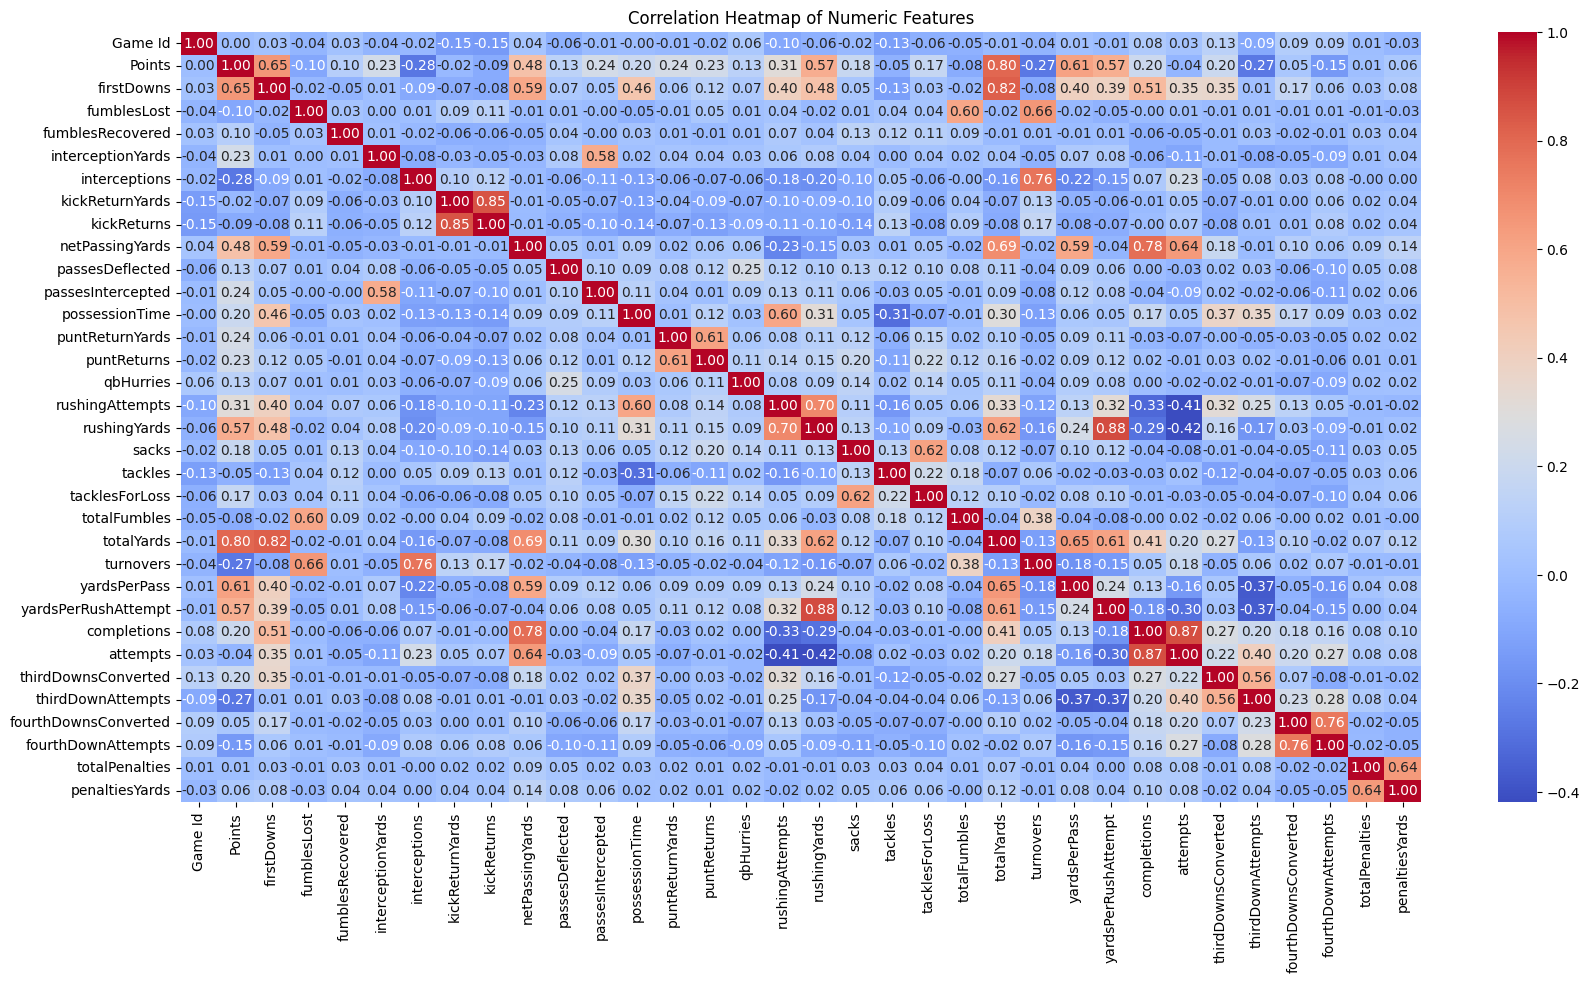

In [21]:
# Correlation Heatmap
corr = game_df_cleaned.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**Observations**

1. `totalYards` must be dropped because it has a very strong correlation (>= 0.8) with `Points` and `firstDowns` as this will cause data leakage.
1. `rushingYards`should be dropped because it very strong correlation (>= 0.8) with `yardsPerRushAttempt`
1. `attempts` should be dropped because it has a very strong correlation (>= 0.8)with `completions`.
1. `kickReturnYards` may be dropped because it has a very strong correlation (>= 0.8) with `kickReturns`.

In [22]:
# Correlated columns to drop
drp_cols = ["totalYards", "rushingYards", "attempts", "kickReturnYards"]
game_df_cleaned.drop(columns=drp_cols, inplace=True)

## Exploring Outliers

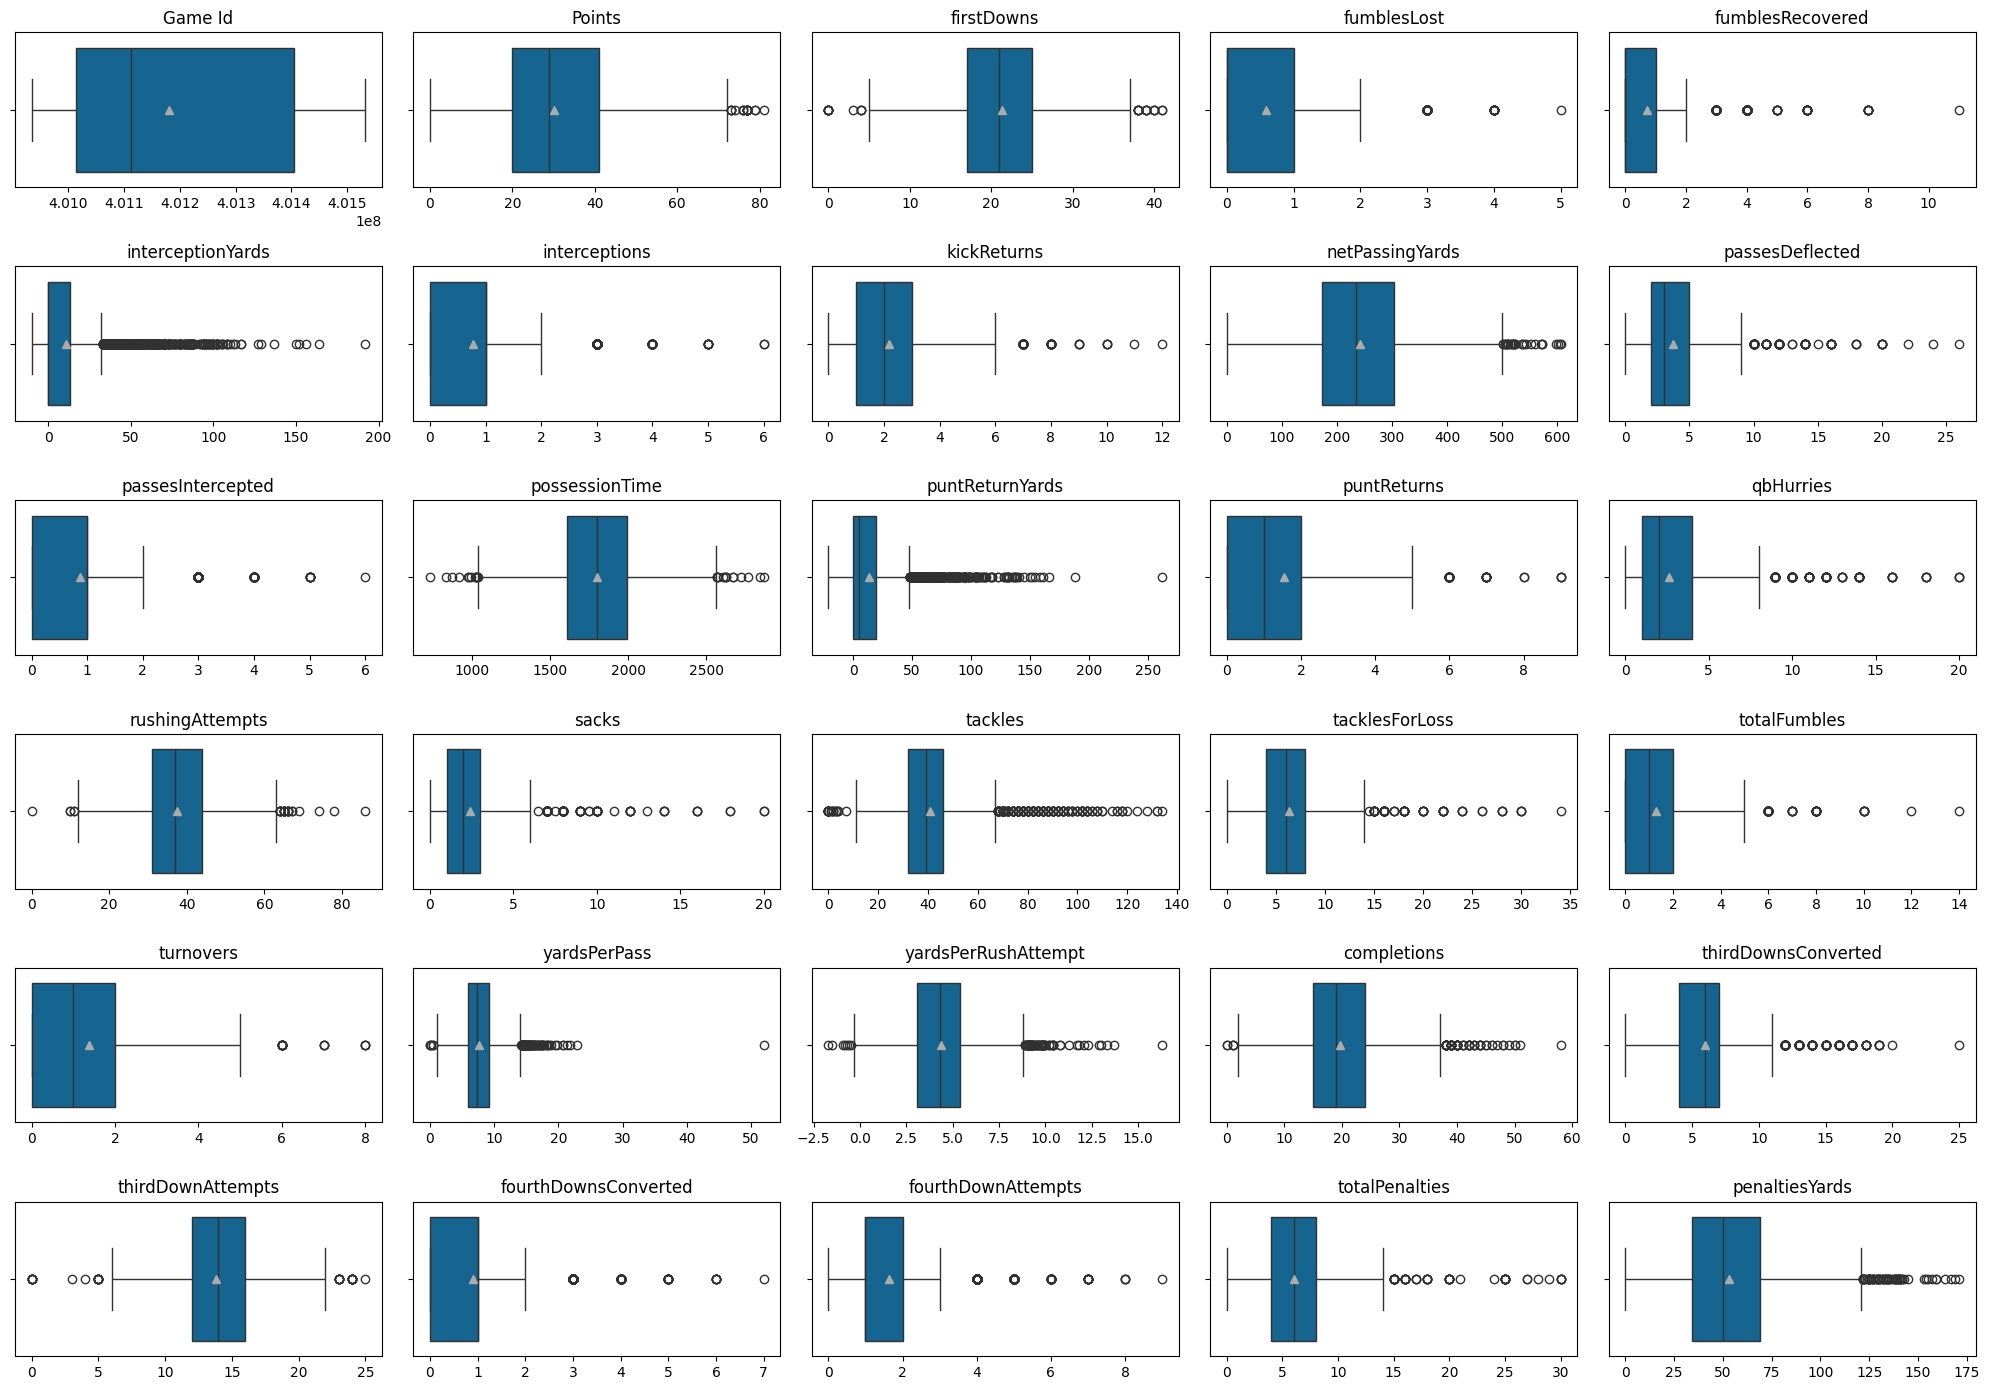

In [23]:
num_col = game_df_cleaned.select_dtypes(include=np.number).columns

# Calculate the number of rows needed for the subplots
num_rows = int(len(num_col) / 5)
plt.figure(figsize=(20, 14))
# Create subplots
for i in range(len(num_col)):
    plt.subplot(num_rows, 5, i + 1)
    sns.boxplot(game_df_cleaned[num_col[i]], orient="h", showmeans=True)
    plt.title(num_col[i])
    plt.gca().set_xlabel("")
    plt.tight_layout()

plt.show();

In [24]:
game_df_cleaned.loc[(game_df_cleaned["puntReturnYards"] > 180), :]

Game Id         School Conference HomeAway  Points  firstDowns  \
3800  401403880        Alabama        SEC     home      63          23   
4601  401411157  Virginia Tech        ACC     home      27          20   

      fumblesLost  fumblesRecovered  interceptionYards  interceptions  \
3800            0                 0              25.00              2   
4601            3                 0               7.00              1   

      kickReturns  netPassingYards  passesDeflected  passesIntercepted  \
3800         1.00              236             3.00               1.00   
4601         3.00              166             5.00               1.00   

      possessionTime  puntReturnYards  puntReturns  qbHurries  \
3800         1417.00           262.00         9.00       4.00   
4601         1608.00           188.00         7.00       6.00   

      rushingAttempts  sacks  tackles  tacklesForLoss  totalFumbles  \
3800               39   4.00    31.00            9.00          3.00   
4601               39   3.00    37.00            5.00          3.00   

      turnovers  yardsPerPass  yardsPerRushAttempt  completions  \
3800          2         11.80                 7.00           13   
4601          4          6.10                 3.50           15   

      thirdDownsConverted  thirdDownAttempts  fourthDownsConverted  \
3800                    1               6.00                     1   
4601                    4              12.00                     0   

      fourthDownAttempts  totalPenalties  penaltiesYards  
3800                3.00            6.00           60.00  
4601                0.00            7.00           55.00

In [25]:
game_df_cleaned.loc[(game_df_cleaned["thirdDownsConverted"] > 20), :]

Game Id   School Conference HomeAway  Points  firstDowns  fumblesLost  \
4357  401405096  Indiana    Big Ten     away      24          27            1   

      fumblesRecovered  interceptionYards  interceptions  kickReturns  \
4357                 0               0.00              2         2.00   

      netPassingYards  passesDeflected  passesIntercepted  possessionTime  \
4357              280             2.00               1.00         1801.00   

      puntReturnYards  puntReturns  qbHurries  rushingAttempts  sacks  \
4357            15.00         4.00       3.00               38   2.00   

      tackles  tacklesForLoss  totalFumbles  turnovers  yardsPerPass  \
4357    34.00            5.00          2.00          3          4.20   

      yardsPerRushAttempt  completions  thirdDownsConverted  \
4357                 1.80           31                   25   

      thirdDownAttempts  fourthDownsConverted  fourthDownAttempts  \
4357                NaN                     0                4.00   

      totalPenalties  penaltiesYards  
4357            0.00           58.00

In [26]:
game_df_cleaned.loc[(game_df_cleaned["yardsPerPass"] > 30), :]

Game Id        School Conference HomeAway  Points  firstDowns  \
1712  401013165  Georgia Tech        ACC     away      38          27   

      fumblesLost  fumblesRecovered  interceptionYards  interceptions  \
1712            3                 0              22.00              0   

      kickReturns  netPassingYards  passesDeflected  passesIntercepted  \
1712         1.00              104             1.00               3.00   

      possessionTime  puntReturnYards  puntReturns  qbHurries  \
1712         2172.00            12.00         1.00       6.00   

      rushingAttempts  sacks  tackles  tacklesForLoss  totalFumbles  \
1712               74   0.00    33.00            7.00          4.00   

      turnovers  yardsPerPass  yardsPerRushAttempt  completions  \
1712          3         52.00                 6.20            2   

      thirdDownsConverted  thirdDownAttempts  fourthDownsConverted  \
1712                    4              11.00                     2   

      fourthDownAttempts  totalPenalties  penaltiesYards  
1712                4.00            3.00           20.00

This value is most likely an error, so it should be replaced with NaN

In [27]:
game_df_cleaned.loc[game_df_cleaned["yardsPerPass"] > 30, "yardsPerPass"] = pd.NA

## Univariate Distribution Visualization

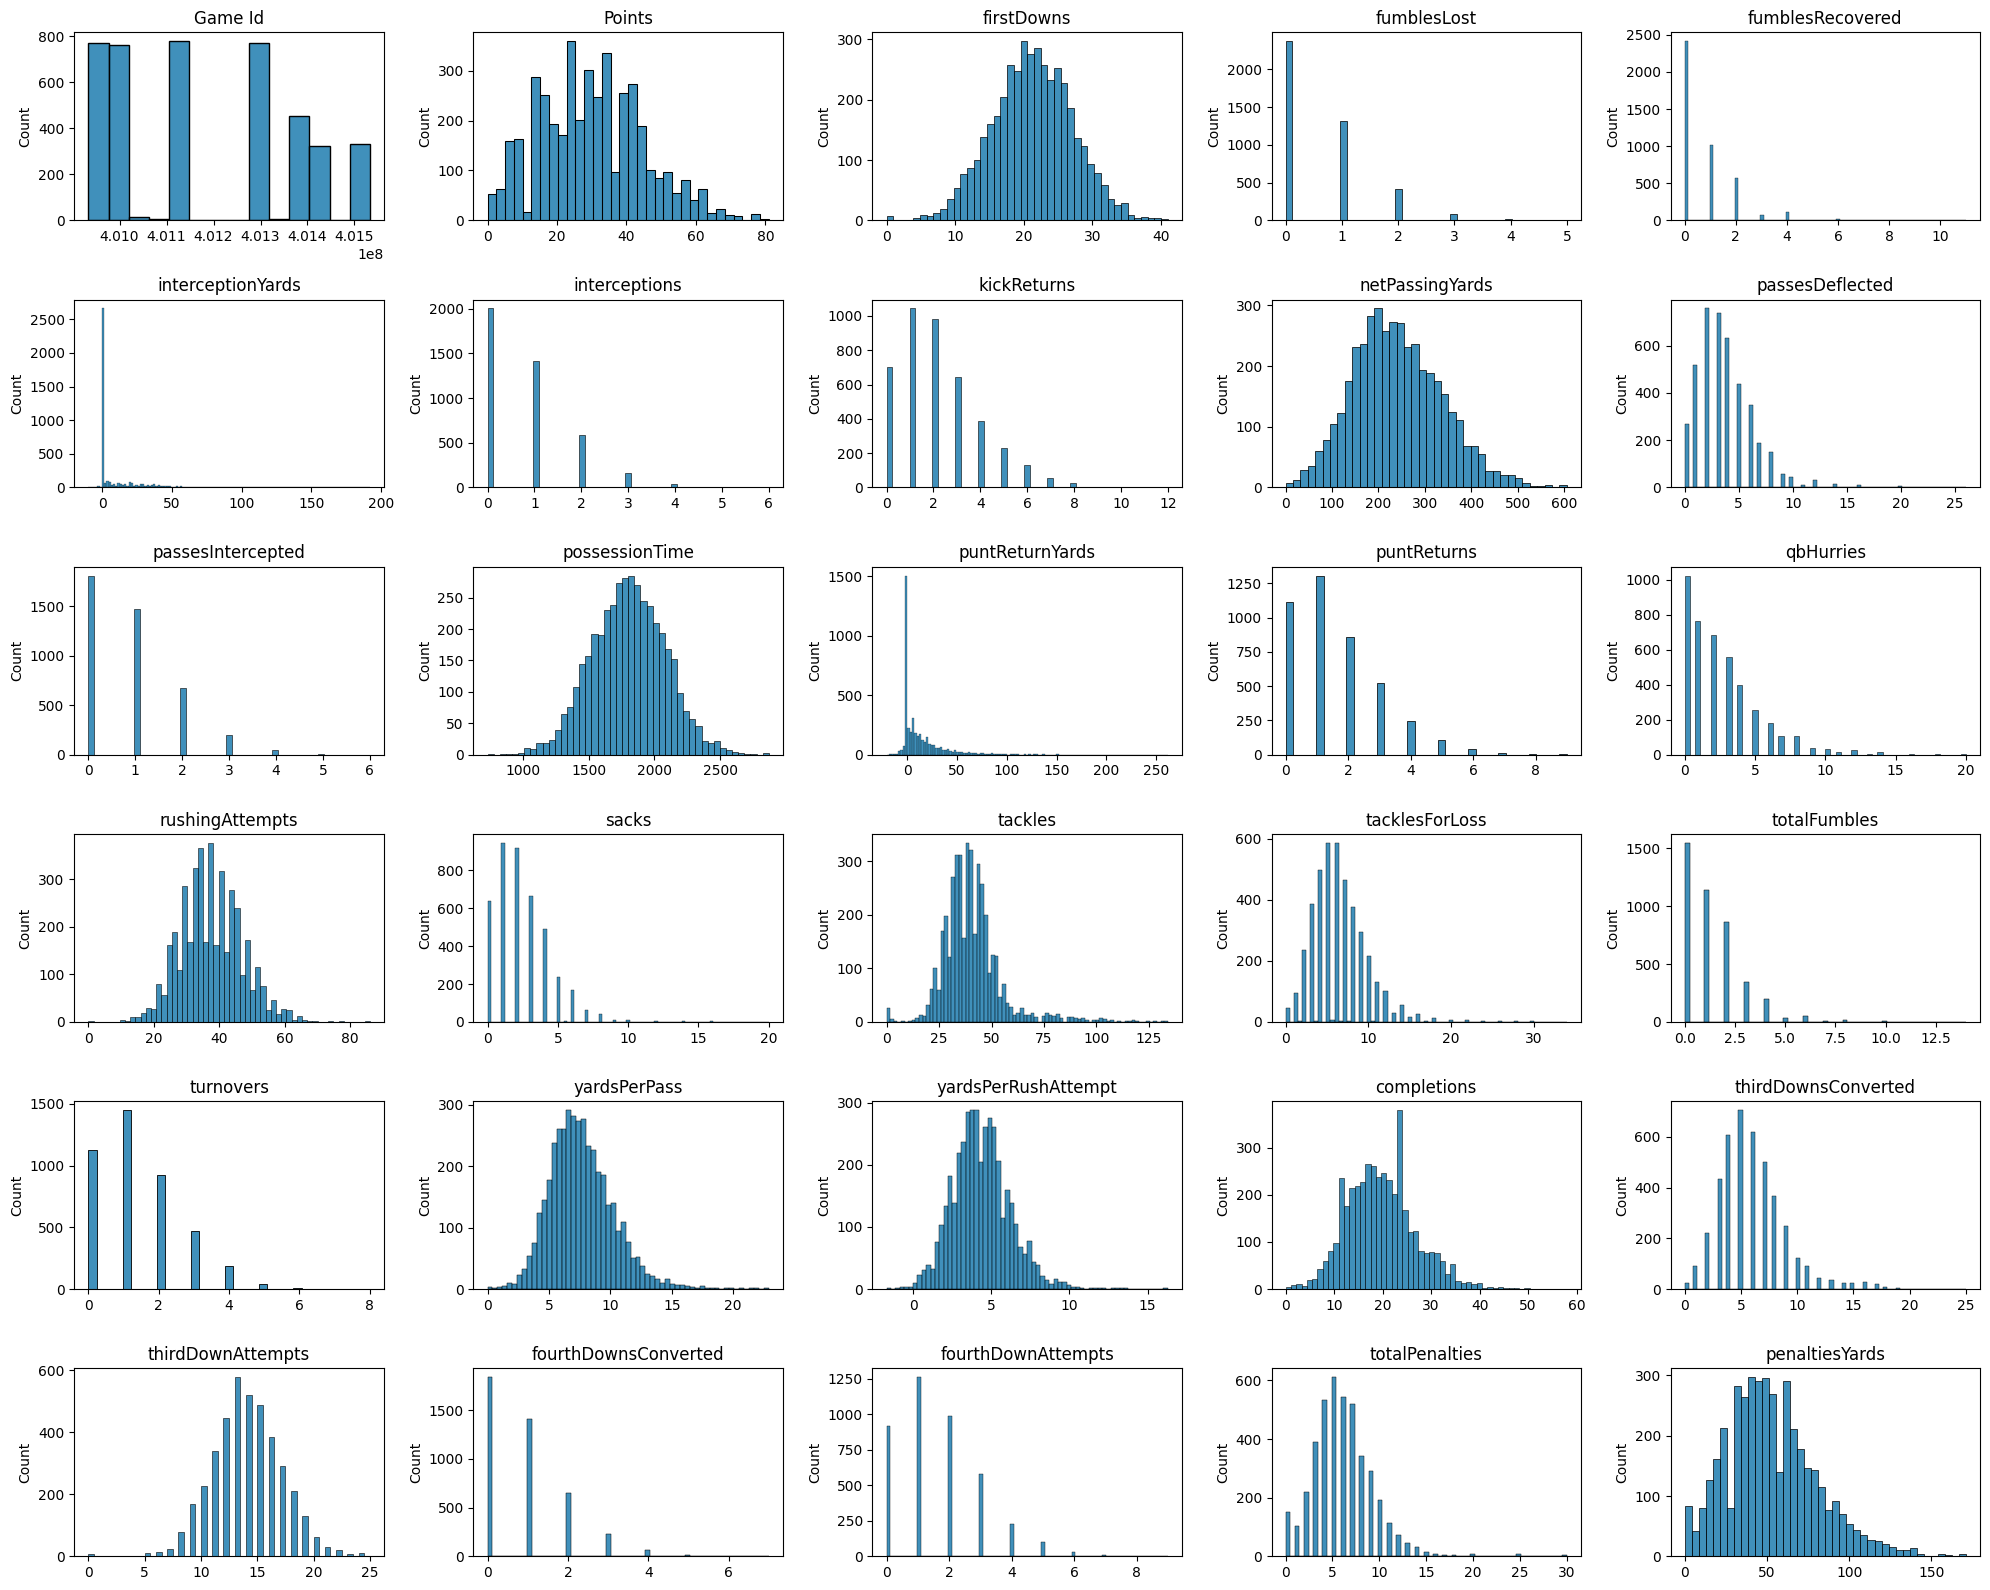

In [28]:
plt.figure(figsize=(20, 16))
# Create subplots
for i in range(len(num_col)):
    plt.subplot(num_rows, 5, i + 1)
    sns.histplot(
        game_df_cleaned[num_col[i]],
    )
    plt.title(num_col[i])
    plt.gca().set_xlabel("")
    plt.tight_layout()

plt.show();

## Exploring Average Yards gained from Punt Returns

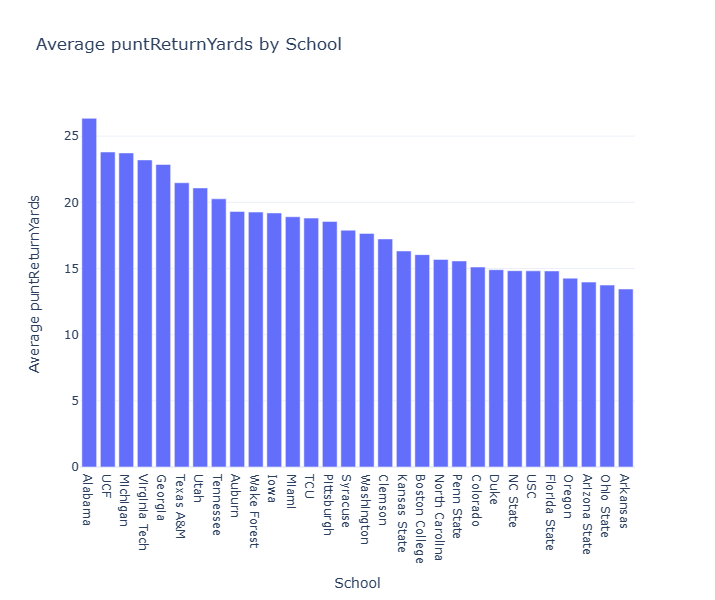

In [29]:
# Calculate the average puntReturnYards by School
avg_puntReturnYards_school = (
    game_df_cleaned.groupby("School")["puntReturnYards"]
    .mean()
    .sort_values(ascending=False)
    .head(30)
)

# Create bar plots
fig7 = px.bar(
    avg_puntReturnYards_school,
    title="Average puntReturnYards by School",
    labels={"value": "Average puntReturnYards", "School": "School"},
    width=1300,
    height=600,
)

fig7.update_xaxes(type="category")
fig7.update_layout(showlegend=False)
fig7.show()

Alabama Crimson Tide Team stands out with a notably higher average, suggesting either a particularly skilled returner or effective special teams coaching. 

A clear downward trend indicates a significant variation in punt return efficiency across schools.

## Exploring Number of Quarterback Hurries.

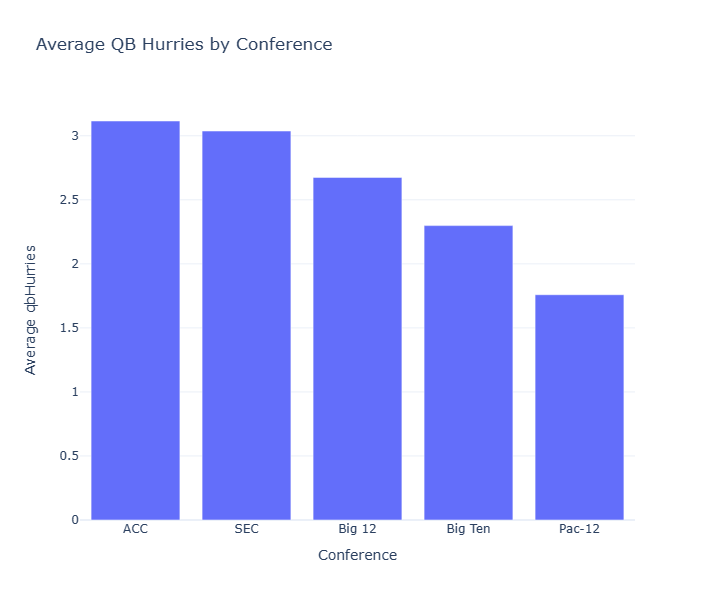

In [30]:
# Calculate the average qbHurries
avg_qbHurries_conference = (
    game_df_cleaned.groupby("Conference")["qbHurries"]
    .mean()
    .sort_values(ascending=False)
)

# Create bar plots
fig5 = px.bar(
    avg_qbHurries_conference,
    title="Average QB Hurries by Conference",
    labels={"value": "Average qbHurries", "Conference": "Conference"},
    width=800,
    height=600,
)
fig5.update_xaxes(type="category")
fig5.update_layout(showlegend=False)
fig5.show()

The ACC and SEC lead, suggesting more aggressive or effective defensive lines or perhaps a style of play in these conferences that prioritizes putting pressure on the quarterback.

## Exploring Average Points Scored

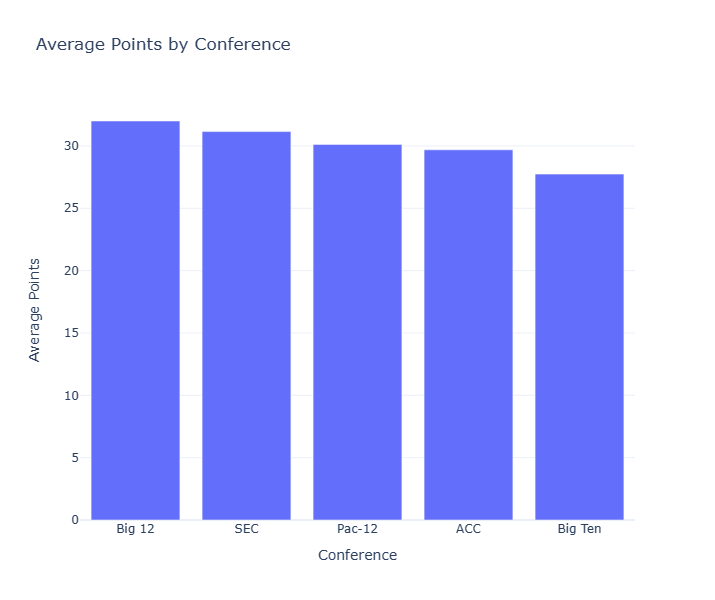

In [31]:
# Calculate the average points
avg_points_conference = (
    game_df_cleaned.groupby("Conference")["Points"].mean().sort_values(ascending=False)
)

# Create bar plot
fig1 = px.bar(
    avg_points_conference,
    title="Average Points by Conference",
    labels={"value": "Average Points", "Conference": "Conference"},
    width=800,
    height=600,
)
fig1.update_layout(showlegend=False)
fig1.show()

The Big 12 leads in scoring, which might suggest a focus on offensive play or possibly weaker defenses within the conference. The Big Ten, on the other hand, has the lowest average, which might reflect a more defense-oriented style of play or stronger overall competition.

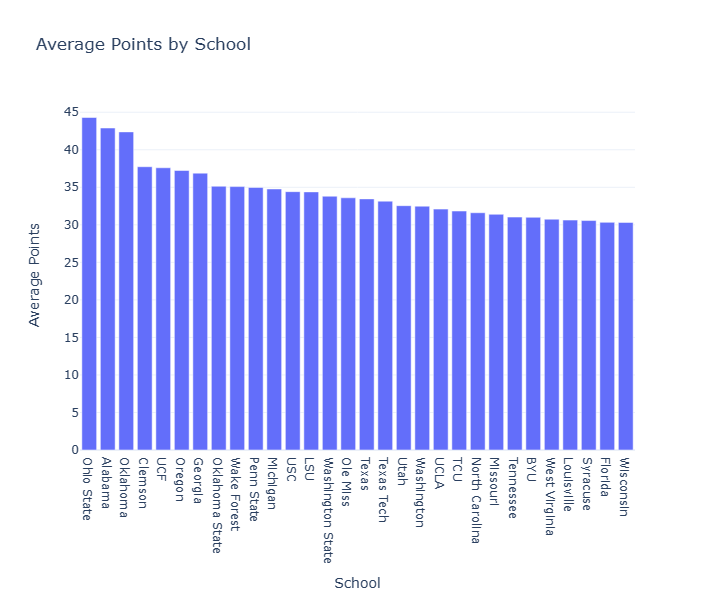

In [32]:
# Calculate the average points
avg_points_school = (
    game_df_cleaned.groupby("School")["Points"]
    .mean()
    .sort_values(ascending=False)
    .head(30)
)

# Create bar plot
fig2 = px.bar(
    avg_points_school,
    title="Average Points by School",
    labels={"value": "Average Points", "School": "School"},
    width=1300,
    height=600,
)
fig2.update_layout(showlegend=False)
fig2.show()

 While most schools appear to have a relatively close range of scoring averages, Ohio State Buckeyes, Alabama Crimson Tide and Oklahoma Sooners significantly outperform the rest, which could be indicative of a stronger offense or weaker competition.

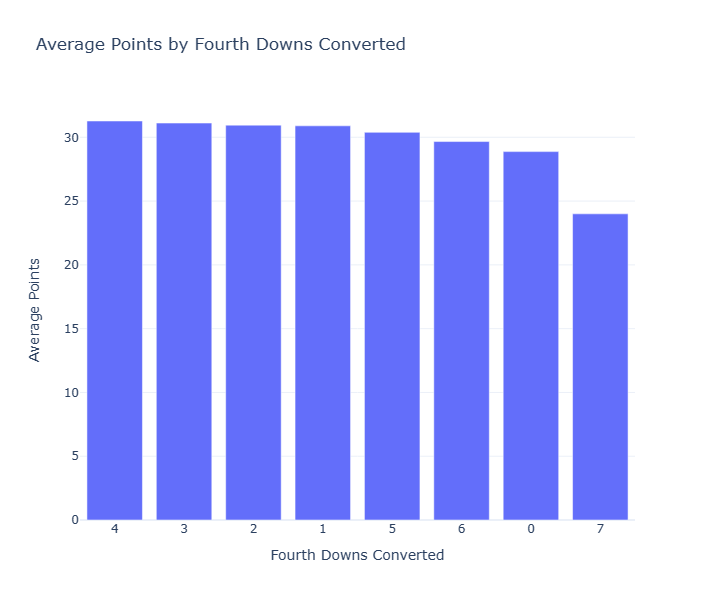

In [33]:
# Calculate the average points
avg_points_fourthDownsConverted = (
    game_df_cleaned.groupby("fourthDownsConverted")["Points"]
    .mean()
    .sort_values(ascending=False)
)

# Create bar plot
fig4 = px.bar(
    avg_points_fourthDownsConverted,
    title="Average Points by Fourth Downs Converted",
    labels={
        "value": "Average Points",
        "fourthDownsConverted": "Fourth Downs Converted",
    },
    width=900,
    height=600,
)
fig4.update_xaxes(type="category")
fig4.update_layout(showlegend=False)
fig4.show()

There appears to be a non-linear relationship between fourth downs converted and average points. Notably, teams converting zero or seven fourth downs have lower average points, which could imply that teams not taking risks or perhaps too many risks may score less overall.

## Feature Engineering

**The following variables will be created using the data**.
* `AvgPointsAllowedPerGame`: It represents the average points allowed by the team's defense
* `avgYardsPerPass` and `avgYardsPerRush`: These features represent the average yards gained per pass and per rush attempt for each team.
* `homeAdvantage`: It indicates if the game was played on the school's home field.se.ch team.

In [34]:
df = game_df_cleaned.copy()

In [35]:
# Calculating average yards per pass and per rush attempt for each team
df["AvgYardsPerPass"] = df.groupby("School")["yardsPerPass"].transform("mean")
df["AvgYardsPerRush"] = df.groupby("School")["yardsPerRushAttempt"].transform("mean")

In [36]:
# Binary encoding for 'HomeAway' field
df["homeAdvantage"] = df["HomeAway"].apply(lambda x: 1 if x == "home" else 0)
df.drop("HomeAway", axis=1, inplace=True)

# Modeling

In [37]:
# Preparing data for modeling with new features
# Dropping categorical and target columns
X = df.drop(["Game Id", "School", "Conference", "Points"], axis=1)

# Target variable
y = df["Points"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Size of the new feature set
X_train.shape, X_test.shape

((2949, 31), (1264, 31))

In [38]:
# Scale ans impute missing values the features
scaler = StandardScaler()
imputer = KNNImputer()

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(scaler.fit_transform(X_train)),
    columns=X_train.columns,
    index=X_train.index,
)
X_test_imputed = pd.DataFrame(
    imputer.transform(scaler.transform(X_test)),
    columns=X_test.columns,
    index=X_test.index,
)

# Verifying the size of the feature set
X_train_imputed.shape, X_test_imputed.shape, y_train.shape, y_test.shape

((2949, 31), (1264, 31), (2949,), (1264,))

## Auto Modeling

In [39]:
######### This is very expensive to run! Proceed with caution ########

# Using TPOTRegressor
# cv = RepeatedKFold(n_repeats=3, random_state=42)

# tpot = TPOTRegressor(
#     generations=5, population_size=5, verbosity=3, cv=cv, random_state=42, n_jobs=-1
# )

# tpot.fit(X_train_imputed, y_train)
# print(tpot.score(X_test, y_test))
# tpot.export("tpot_result.py")

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/30 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	-62.346754763002686	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.7500000000000001, RandomForestRegressor__min_samples_leaf=11, RandomForestRegressor__min_samples_split=9, RandomForestRegressor__n_estimators=100)

-2	-45.42978207351686	RandomForestRegressor(ElasticNetCV(input_matrix, ElasticNetCV__l1_ratio=0.75, ElasticNetCV__tol=0.01), RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.4, RandomForestRegressor__min_samples_leaf=16, RandomForestRegressor__min_samples_split=14, RandomForestRegressor__n_estimators=100)

Generation 2 - Current Pareto front scores:

-1	-62.346754763002686	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.7500000000000001, RandomForestRegressor__min_samples_leaf=11, RandomForestRegressor__min_samples_split=9, RandomForestRegressor__n_estimators=100)

-2	-4

In [40]:
# Using LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False)
models, predictions = reg.fit(X_train_imputed, X_test_imputed, y_train, y_test)

print(models)

 21%|█████████████████▊                                                                 | 9/42 [00:05<00:27,  1.22it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|████████████████████████████████████████████████████████████████▍                 | 33/42 [00:11<00:01,  5.77it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:19<00:00,  2.16it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 2949, number of used features: 31
[LightGBM] [Info] Start training from score 29.951848
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BayesianRidge                                0.78       0.79  6.87        0.01
RidgeCV                                      0.78       0.79  6.87        0.02
LassoLarsCV                                  0.78       0.79  6.87        0.03
LassoCV                                      0.78       0.79  6.87        0.12
ElasticNetCV                                 0.78       0.79  6.87        0.10
Ridge                                        0.78       0.79  6.87        0.01
LassoLarsIC               

## Fitting Stacking Estimator with  ElasticNetCV and Random ForestRegressor 

In [41]:
# Setting up the pipeline
pipeline = make_pipeline(
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.9, tol=0.001)),
    RandomForestRegressor(
        bootstrap=True,
        max_features=0.75,
        min_samples_leaf=16,
        min_samples_split=14,
        n_estimators=100,
    ),
)

pipeline

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.9,
                                                          tol=0.001))),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.75, min_samples_leaf=16,
                                       min_samples_split=14))])

In [42]:
# Fit the pipeline to the training data
pipeline.fit(X_train_imputed, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test_imputed)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Coefficient of Determination (R²):", r2)

Mean Absolute Error (MAE): 5.195649087541267
Mean Squared Error (MSE): 45.632471335748576
Coefficient of Determination (R²): 0.7956642170286158


## Fitting Linear Regression model

In [43]:
# Adding a constant to the model
X_train_const = sm.add_constant(X_train_imputed)
X_test_const = sm.add_constant(X_test_imputed, has_constant="add")


# Function to build OLS model
def build_ols_model(train, target):
    ols_model = sm.OLS(target, train)
    return ols_model.fit()


# Create and summarize OLS model
ols_model = build_ols_model(X_train_const, y_train)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     400.0
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:25:25   Log-Likelihood:                -9760.2
No. Observations:                2949   AIC:                         1.958e+04
Df Residuals:                    2918   BIC:                         1.977e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   30.0413 

* Both the R-squared and Adjusted R squared of our model are high. This is an indication that we have been able to create a model that is able to explain variance in Points Scored for up to 80% 
* The model is not an underfitting model.
* To be able to make statistical inferences from our model, we will have to test that the linear regression assumptions are followed.
* Before we move on to assumption testing, we'll do a quick performance check on the test data.

In [44]:
# Metrics for Model Performance
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Function to evaluate model performance
def model_perf(ols_model, x_train, x_test, y_train, y_test):
    y_pred_train = ols_model.predict(x_train)
    y_pred_test = ols_model.predict(x_test)

    metrics = pd.DataFrame(
        {
            "Data": ["Train", "Test"],
            "RMSE": [rmse(y_pred_train, y_train), rmse(y_pred_test, y_test)],
            "MAE": [mae(y_pred_train, y_train), mae(y_pred_test, y_test)],
        }
    )

    print(metrics)


# Checking model performance for overfitting
model_perf(ols_model, X_train_const, X_test_const, y_train, y_test)

    Data  RMSE  MAE
0  Train  6.62 5.19
1   Test  6.87 5.25


* Root Mean Squared Error of train and test data is slightly different, indicating that our model is slightly overfitting the train data. 
* Mean Absolute Error indicates that our current model is able to predict points scored within mean error of 5.2 points on test data.

## Checking the Linear Regression Assumptions

1. No Multicollinearity
2. Mean of residuals should be 0
3. No Heteroscedasticity
4. Linearity of variables
5. Normality of error terms

### Checking Assumption 1: No Multicollinearity 

We will use VIF, to check if there is multicollinearity in the data.

Features having a VIF score >5 will be dropped/treated till all the features have a VIF score <5

In [45]:
# Function to check VIF
def check_vif(dataframe):
    try:
        vif = pd.DataFrame()
        vif["Feature"] = dataframe.columns
        vif["VIF"] = [
            variance_inflation_factor(dataframe.values, i)
            for i in range(dataframe.shape[1])
        ]
        return vif
    except Exception as e:
        print(f"Error calculating VIF: {e}")
        return None


# Function to add a constant to the dataframe
def add_constant(dataframe):
    return sm.add_constant(dataframe)


# Checking VIF for the initial model
print(check_vif(X_train_imputed))

                 Feature   VIF
0             firstDowns  6.92
1            fumblesLost   inf
2       fumblesRecovered  1.06
3      interceptionYards  1.55
4          interceptions   inf
5            kickReturns  1.11
6        netPassingYards 12.96
7        passesDeflected  1.14
8      passesIntercepted  1.62
9         possessionTime  2.47
10       puntReturnYards  1.63
11           puntReturns  1.79
12             qbHurries  1.12
13       rushingAttempts  6.58
14                 sacks  1.63
15               tackles  1.32
16        tacklesForLoss  1.72
17          totalFumbles  1.69
18             turnovers   inf
19          yardsPerPass  5.91
20   yardsPerRushAttempt  2.04
21           completions  7.20
22   thirdDownsConverted  2.23
23     thirdDownAttempts  3.97
24  fourthDownsConverted  2.39
25    fourthDownAttempts  2.70
26        totalPenalties  1.70
27        penaltiesYards  1.76
28       AvgYardsPerPass  1.99
29       AvgYardsPerRush  1.94
30         homeAdvantage  1.11


**Observations**

* `fumblesLost`, `interceptions` and `turnovers` have a VIF score of inf indicating perfect correlation.
* `netPassingYards` have a VIF score greater than 10

### Removing Multicollinearity

1. Drop every column one by one that has VIF score greater than 10.
1. Look at the adjusted R square of all these models
1. Drop the Variable that makes least change in Adjusted-R square
1. Check the VIF Scores again
1. Continue till you get all VIF scores under 10

In [46]:
# Dropping feature with the highest VIF and checking again
X_train_dropped = X_train_imputed.drop("fumblesLost", axis=1)
X_test_dropped = X_test_imputed.drop("fumblesLost", axis=1)

# Add constant to the dataframe for OLS modeling
X_train_const2 = add_constant(X_train_dropped)
X_test_const2 = add_constant(X_test_dropped)

print(check_vif(X_train_const2))

                 Feature   VIF
0                  const  1.00
1             firstDowns  6.93
2       fumblesRecovered  1.06
3      interceptionYards  1.55
4          interceptions  3.28
5            kickReturns  1.11
6        netPassingYards 12.97
7        passesDeflected  1.14
8      passesIntercepted  1.62
9         possessionTime  2.47
10       puntReturnYards  1.63
11           puntReturns  1.79
12             qbHurries  1.12
13       rushingAttempts  6.58
14                 sacks  1.63
15               tackles  1.32
16        tacklesForLoss  1.72
17          totalFumbles  1.69
18             turnovers  3.81
19          yardsPerPass  5.92
20   yardsPerRushAttempt  2.04
21           completions  7.20
22   thirdDownsConverted  2.24
23     thirdDownAttempts  3.98
24  fourthDownsConverted  2.39
25    fourthDownAttempts  2.70
26        totalPenalties  1.70
27        penaltiesYards  1.76
28       AvgYardsPerPass  1.99
29       AvgYardsPerRush  1.94
30         homeAdvantage  1.11


In [47]:
# Building and summarizing the new OLS model
ols_model2 = build_ols_model(X_train_const2, y_train)
print(ols_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     400.0
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:25:26   Log-Likelihood:                -9760.2
No. Observations:                2949   AIC:                         1.958e+04
Df Residuals:                    2918   BIC:                         1.977e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   30.0413 

**Observation**
* All variables except `netPassingYards` now has VIF score less than 10
* Dropping `fumblesLost` had no effect on the model performance.

In [48]:
# we drop "netPassingYards"and check the Adjusted-R Squared
X_train_const3 = X_train_const2.drop("netPassingYards", axis=1)
X_test_const3 = X_test_const2.drop("netPassingYards", axis=1)

# Add constant to the dataframe for OLS modeling
X_train_const3 = add_constant(X_train_const3)
X_test_const3 = add_constant(X_test_const3)

print(check_vif(X_train_const3))

                 Feature  VIF
0                  const 1.00
1             firstDowns 5.28
2       fumblesRecovered 1.06
3      interceptionYards 1.55
4          interceptions 3.28
5            kickReturns 1.11
6        passesDeflected 1.14
7      passesIntercepted 1.62
8         possessionTime 2.45
9        puntReturnYards 1.63
10           puntReturns 1.78
11             qbHurries 1.12
12       rushingAttempts 5.45
13                 sacks 1.63
14               tackles 1.31
15        tacklesForLoss 1.72
16          totalFumbles 1.69
17             turnovers 3.80
18          yardsPerPass 1.79
19   yardsPerRushAttempt 1.99
20           completions 5.32
21   thirdDownsConverted 2.16
22     thirdDownAttempts 3.34
23  fourthDownsConverted 2.39
24    fourthDownAttempts 2.68
25        totalPenalties 1.70
26        penaltiesYards 1.76
27       AvgYardsPerPass 1.99
28       AvgYardsPerRush 1.94
29         homeAdvantage 1.11


In [49]:
ols_model3 = build_ols_model(X_train_const3, y_train)
print(ols_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     383.8
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:25:26   Log-Likelihood:                -9849.2
No. Observations:                2949   AIC:                         1.976e+04
Df Residuals:                    2919   BIC:                         1.994e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   30.0032 

**Observations**

* We have removed multicollinearity from the data now
* Dropping `netPassingYards` reduced the Adjusted R2 Score to 79%

### Checking Assumption 2: Mean of residuals should be 0

In [50]:
residuals = ols_model3.resid
np.mean(residuals)

1.869481548580067e-14

Mean of redisuals is very close to 0. The second assumption is also satisfied.

### Checking Assumption 3: No Heteroscedasticity

* Homoscedacity - If the residuals are symmetrically distributed across the regression line , then the data is said to homoscedastic.

* Heteroscedasticity- - If the residuals are not symmetrically distributed across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form a funnel shape or any other non symmetrical shape.

We'll use `Goldfeldquandt Test` to test the following hypothesis

Null hypothesis : Residuals are homoscedastic
Alternate hypothesis : Residuals have hetroscedasticity

alpha = 0.05 

In [51]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, X_train_const3)
lzip(name, test)

[('F statistic', 0.8491506800805777), ('p-value', 0.9990488967969766)]

Since p-value > 0.05 we cannot reject the Null Hypothesis that the residuals are homoscedastic. 

Assumptions 3 is also satisfied by our olsmodel3.

### Checking Assumption 4: Linearity of variables

Predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x axis.

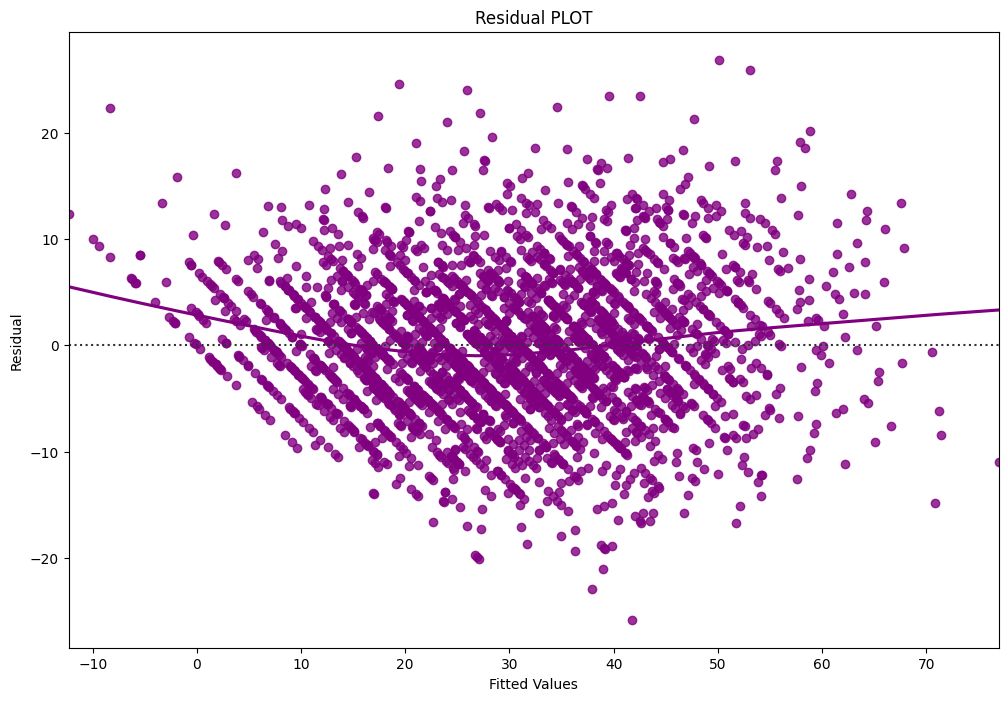

In [52]:
# predicted values
fitted = ols_model3.fittedvalues

sns.residplot(x=fitted, y=residuals, color="purple", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

Assumptions 4 is satisfied by our olsmodel3. There is no pattern in the residual vs fitted values plot.

### Checking Assumption 5: Normality of error terms

The residuals should be normally distributed.

<Axes: ylabel='Density'>

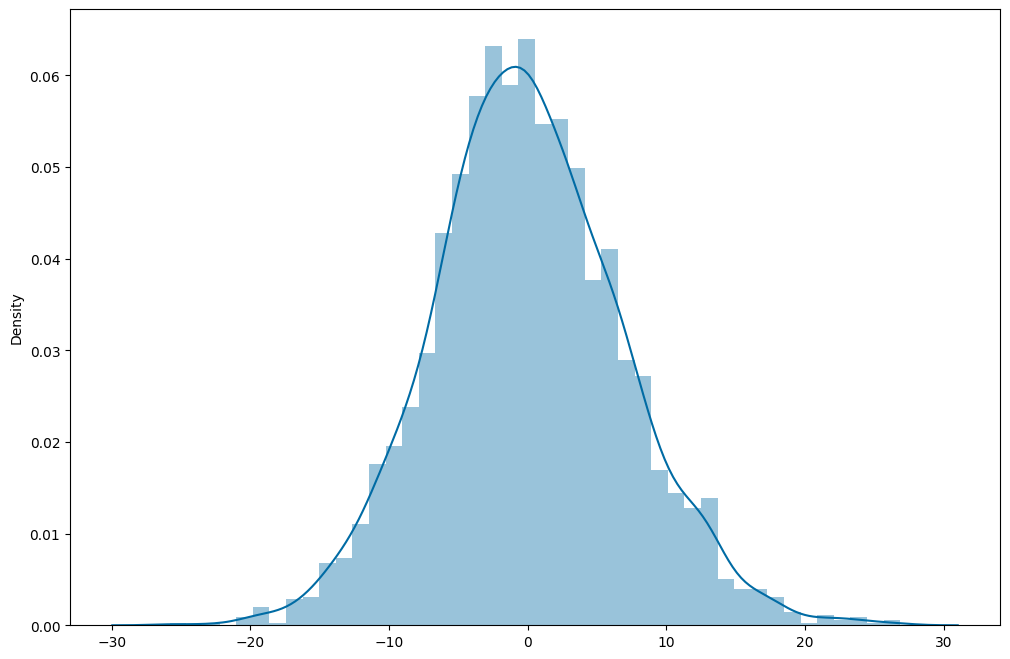

In [53]:
# Plot histogram of residuals
sns.distplot(residuals)

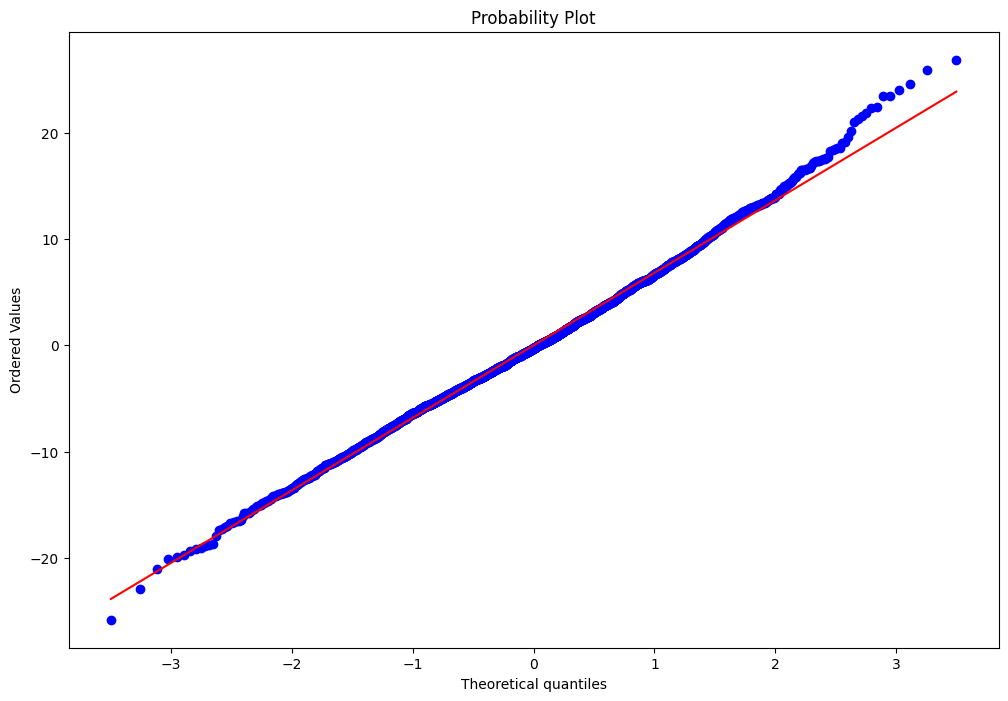

In [54]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

The residuals have a close to normal distribution. Assumption 5 is also satisfied.

Now that we have seen that olsmodel3 follows all the linear regression assumptions. Let us use that model to draw inferences.

In [55]:
print(ols_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     383.8
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:25:27   Log-Likelihood:                -9849.2
No. Observations:                2949   AIC:                         1.976e+04
Df Residuals:                    2919   BIC:                         1.994e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   30.0032 

## Model Interpretation

Our regression analysis indicates a strong model with an R-squared value of 79.2%, suggesting that approximately 80% of the variance in the Total Game Points can be explained by the predictors included in the model. Significant predictors with a p-value less than 0.05, indicating a strong statistical significance, include:

* **First Downs**: Positive correlation; each additional First Down is associated with an increase of 4.67 points.
* **Average Yards Per Pass**: Positive correlation; for each yard increase in passing, the Total Game Points increase by about 4.47 points.
* **Fourth Downs Converted**: Positive correlation; each successful conversion is associated with an increase of 2.31 points.
* **Fourth Down Attempts**: Negative correlation; each additional attempt is associated with a decrease of 2.09 points.
* **Total Turnovers**: Negative correlation; each turnover is associated with a decrease of 1.93 points.

The model also identified other significant variables such as Yards Gained from Punt Returns and Interceptions, as well as Fumbles Recovered. It is crucial to note that these relationships are correlational and do not imply causation. For example, while Fourth Down Attempts are negatively correlated with Total Game Points, this does not necessarily mean that attempting more fourth downs causes a lower score. It could be reflective of game strategy in specific scenarios.

In [56]:
linearregression = LinearRegression()
linearregression.fit(X_train_imputed, y_train)

print("Intercept of the linear equation is", linearregression.intercept_)
print("")
for idx, col_name in enumerate(X_train_prepared.columns):
    print("The coefficient for {} is {}".format(col_name, linearregression.coef_[idx]))

pred = linearregression.predict(X_test_imputed)

Intercept of the linear equation is 30.059717325690315



NameError: name 'X_train_prepared' is not defined

In [ ]:
# Initialize models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(random_state=42)
gradient_boosting_model = GradientBoostingRegressor(random_state=42)


# Function to evaluate a model using cross-validation
def evaluate_model(model, X, y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=5)
    return mse.mean(), mae.mean()


# Calculating mean_squared_error and mean_absolute_error  for each model
linear_mse, linear_mae = evaluate_model(linear_model, X_train_imputed, y_train)
rf_mse, rf_mae = evaluate_model(random_forest_model, X_train_imputed, y_train)
gb_mse, gb_mae = evaluate_model(gradient_boosting_model, X_train_imputed, y_train)


# Function to calculate R^2 and Adjusted R^2
def calculate_r2_scores(model, X, y):
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=5)
    n = len(y)  # Number of observations
    k = X.shape[1]  # Number of features
    adjusted_r2_scores = 1 - (1 - r2_scores) * (n - 1) / (n - k - 1)
    return r2_scores.mean(), adjusted_r2_scores.mean()


# Calculating R^2 and Adjusted R^2 for each model
linear_r2, linear_adjusted_r2 = calculate_r2_scores(
    linear_model, X_train_imputed, y_train
)
rf_r2, rf_adjusted_r2 = calculate_r2_scores(
    random_forest_model, X_train_imputed, y_train
)
gb_r2, gb_adjusted_r2 = calculate_r2_scores(
    gradient_boosting_model, X_train_imputed, y_train
)

In [ ]:
# DataFrame to display the scores in a tabular format
model_scores = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
        "R2 Score": [linear_r2, rf_r2, gb_r2],
        "Adjusted R2 Score": [linear_adjusted_r2, rf_adjusted_r2, gb_adjusted_r2],
        "MSE": [linear_mse, rf_mse, gb_mse],
        "MAE": [linear_mae, rf_mae, gb_mae],
    }
)

model_scores

In [ ]:
# DataFrame to display the scores in a tabular format
model_scores = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
        "R2 Score": [linear_r2, rf_r2, gb_r2],
        "Adjusted R2 Score": [linear_adjusted_r2, rf_adjusted_r2, gb_adjusted_r2],
        "MSE": [linear_mse, rf_mse, gb_mse],
        "MAE": [linear_mae, rf_mae, gb_mae],
    }
)

model_scores

In [ ]:
# DataFrame to display the scores in a tabular format
model_scores = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
        "R2 Score": [linear_r2, rf_r2, gb_r2],
        "Adjusted R2 Score": [linear_adjusted_r2, rf_adjusted_r2, gb_adjusted_r2],
        "MSE": [linear_mse, rf_mse, gb_mse],
        "MAE": [linear_mae, rf_mae, gb_mae],
    }
)

model_scores

Based on these metrics, the **Gradient Boosting Regressor** has the best performance, with the lowest MAE and MSE, and the highest R2 score, indicating a strong fit to the data.

In [ ]:
# Defining the parameter grid for Gradient Boosting
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 4, 6],
}

# Creating the Grid Search object
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

# Fitting Grid Search to the data
grid_search.fit(X_train_imputed, y_train)

# Best parameters
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

best_params, best_mse

The optimal parameters identified are:

* Learning Rate: 0.1
* Max Depth: 4
* Min Samples Split: 4
* Number of Estimators: 300

And the best Mean Squared Error (MSE) achieved with these parameters is 33.154.

In [ ]:
# Training the final Gradient Boosting model with the optimal hyperparameters
final_gb_model = GradientBoostingRegressor(
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    n_estimators=best_params["n_estimators"],
    random_state=42,
)

final_gb_model.fit(X_train_imputed, y_train)

# Predicting on the test set
y_pred = final_gb_model.predict(X_test_imputed)

# Evaluating the model
final_mse = mean_squared_error(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = final_gb_model.score(X_test_imputed, y_test)
n, k = X_test_imputed.shape
final_adjusted_r2 = 1 - (1 - final_r2) * (n - 1) / (n - k - 1)

# DataFrame to display the scores in a tabular format
final_scores = pd.DataFrame(
    {
        "Model": ["Gradient Boosting with Hyperparameters Tuning"],
        "R2 Score": [final_r2],
        "Adjusted R2 Score": [final_adjusted_r2],
        "MSE": [final_mse],
        "MAE": [final_mae],
    }
)

final_scores

In [ ]:
from sklearn.model_selection import GridSearchCV

# Setting up hyperparameter grid for tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}

# Creating the GridSearchCV object
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train_top, y_train)

# Best parameters and best score (MSE)
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score